In [1]:
%load_ext autoreload
%autoreload 2 

# Standard modules
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from hetgpy import homGP, hetGP
import pandas as pd
import yaml
from typing import Dict
import json
import time
from collections import Counter, defaultdict

# EMEWS modules
from eqsql import worker_pool, db_tools, cfg
from eqsql.task_queues import local_queue

# Helper functions
from helpers import *

## Bayesian Optimization of the Zombies model

This notebook contains a complete worked example of finding the optimal parameters of a simple simulation model using EMEWS. 

### Generate grid and initial design

Our goal is to find the combination of **zombie step size** and **human step size** that results in the highest human survival rate in the simulation. For this design, we consider **30 human step sizes between 1 and 3** and **30 zombie step sizes between 0.1 and 1** (for 900 possible parameter combinations). We select 5 parameter combinations to initialize the BO procedure, shown below. 

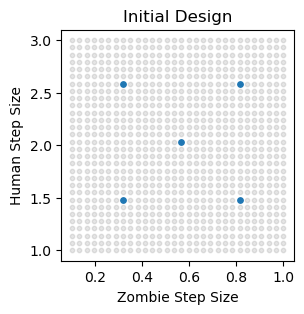

In [2]:
# Set up unit grid (the BO procedure needs input values between 0 and 1)
xx = np.linspace(0, 1, 30)
Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
# Scale the grid to the desired step sizes
Xgrid_native = to_native(Xgrid, lb=np.array([0.1, 1]), ub=np.array([1, 3]))

# Index of initial points (chosen for a well-spaced design) 
init_ids = [217, 233, 465, 697, 713]

plt.figure(figsize=(3,3))
plt.scatter(Xgrid_native[:,0], Xgrid_native[:,1], c='grey', alpha=.2, s=10)
plt.scatter(Xgrid_native[init_ids,0], Xgrid_native[init_ids,1], s=15)
plt.xlabel('Zombie Step Size')
plt.ylabel('Human Step Size')
plt.title('Initial Design')
plt.show()

### Setup EMEWS DB
Next, we start the EMEWS database, local task queues, and worker pools. 

In [ ]:
config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)

exp_id = 1
# start database
db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
db_started = True

# start local task queue
task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                            port=None, db_name=params['db_name'])

# check if the input and output queues are empty,
# if not, then exit with a warning.
if not task_queue.are_queues_empty():
    print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
    task_queue.clear_queues()


# start worker pool
pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                    exp_id, pool_params)
task_type = params['task_type']

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.11/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/Users/abbystevens/Documents/db/emews_db/db.log
Database server started


### Initialize Bayesian Optimization procedure

Because the Zombies model is **stochastic** (meaning that for the same combination of parameters, different random seeds will result in different outcomes), our optimization procedure will proceed as follows. First, we will evalute our initial design points for 3 different random seeds (known a **replicates**). We fit a **Gaussian Process (GP)** model on these initial 15 points using **hetGPy** (a Python implementation of [hetGP](https://cran.r-project.org/web/packages/hetGP/vignettes/hetGP_vignette.pdf), which is designed to handle replicates well). Based on the predicted mean surface and covariance of this GP model, we will select additional points to evaluate following the [Thompson Sampling](https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf) procedure. We will evaluate these points one replicate at a time; if a point that has already been evaluated is selected again, we will re-evaluate it with a new random seed.

In [4]:
# Set the computational budget/total number of simulations we want to run
budget = 50

# Set the number of points we will sample each iteration
nts = 10

# Generate list of random seeds to iterate over
seeds = np.random.choice(1000, 100, replace=False)

# Set number of initial replicates and subtract from budget
init_reps = 3
budget -= len(init_ids)*init_reps

# Setup counters and initial seeds for tracking which new replicates to evalute
init_ids = {x:init_reps for x in init_ids}
init_seeds = seeds[:init_reps]
id_counter = Counter()

### Submit initial payload to EMEWS

We are now ready to run the simulation with EMEWS. In the `../swift/eqsql_worker_pool.swift` file, we define a function `update_params_t` that tells us the format EMEWS expects to submit a job: 

```
params = {'human_step_size': steps[1], 'zombie_step_size': steps[0],
          'counts_file': counts_file, 'random.seed': int(steps[2])}
```

We've defined the function `generate_inputs` in `helpers.py` that takes the entire grid, the index locations of parameters to evaluate, the counter, and the random seeds and generates matrices in the in required format (in their native units with the associated random seed), in addition to a scaled version to use for the GP. 

We convert these matrices to JSON and submit them as payloads to the EMEWS task queue. Once the jobs are complete, we retrieve the results and scale them for appropriate use in the GP.

In [6]:
# Generate inputs in required format
X, Xnative = generate_inputs(Xgrid, init_ids, id_counter, seeds)

# Submit initial inputs to EMEWS and retrieve results
payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
_, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])

# Scale the outputs for numerical stability in the GP fitting
Y = np.log(Y)
ymean, ystd = Y.mean(), Y.std()
Y = (Y-ymean)/ystd

#### Fit GP on initial design
To begin the optimization process, we begin by fitting a GP model to these initial points. The parameters we've specified in the model were selected after some intial experimentation. After fitting the model, we predict the mean surface and variance over the entire grid of potentital parameters and plot them.

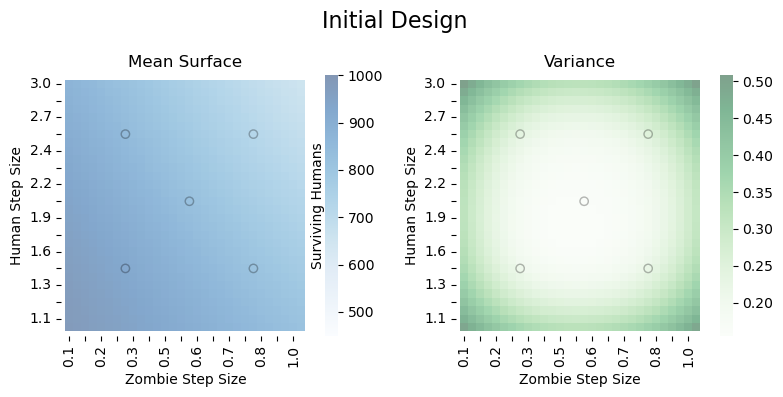

In [7]:
# Fit hetGP model on initial data
gp = hetGP()
gp.mle(X, Y, upper=np.array([100, 100]), init={'g_bounds':[1e-6, .1]})

# Plot mean surface, variance, and initial points
plot_gp(gp, Xgrid, X, ymean, ystd, title='Initial Design')

We see that the predicted surface shows more human survivors toward the origin, but also much higher variance. The Thompson Sampling (TS) optimization procedure draws samples from a multivariate normal distrubtion with mean and covariance set to the values from the GP predictions. We find the location of the maximum value for each of these samples and run the simulation at these points. 

#### First TS iteration

To demonstrate, we perform the TS after the initial design, which selects the parameters shown below. Note that, due to numerical issues, the predicted covariance is not always positive semi-definite; if this is the case, we clip the negative eigenvalues and reconstruct the covariance matrix.

Covariance matrix is not positive semidefinite. Clipping negative eigenvalues.


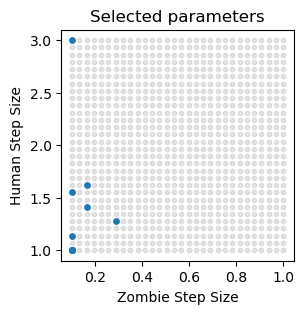

In [8]:
# Thompson sample to find the next points to evaluate
best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))

# Create inputs in required format
Xnew, Xnew_native = generate_inputs(Xgrid, best_ids, id_counter, seeds)

# Plot new locations
plt.figure(figsize=(3,3))
plt.scatter(Xgrid_native[:,0], Xgrid_native[:,1], c='grey', alpha=.2, s=10)
plt.scatter(Xnew_native[:,0], Xnew_native[:,1], s=15)
plt.xlabel('Zombie Step Size')
plt.ylabel('Human Step Size')
plt.title('Selected parameters')
plt.show()

Next, we evaluate the Zombies model for these new parameters by submitting them to the EMEWS task queue and update the budget. We then refit the GP with all locations that have currently been evaluated and plot the updated predicted surface. Darker circles indicate that a location has been selected multiple times.

After iteration 1, we find that 991 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


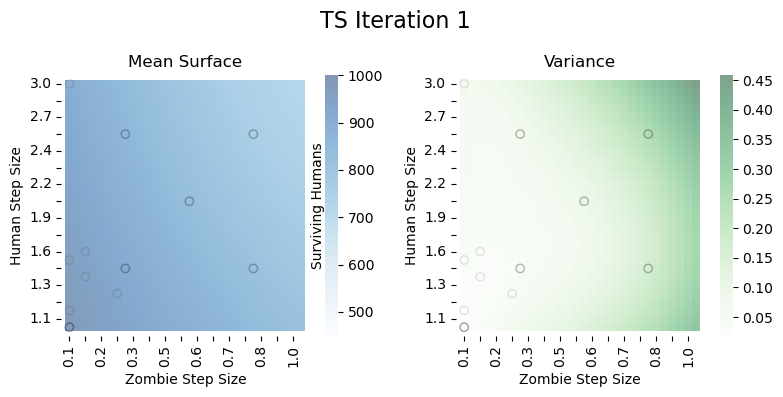

In [9]:
# Submit payloads to task queue
payloads = list(map(lambda a: json.dumps(list(a)), Xnew_native))
_, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
Ynew = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
# subtract from budget 
budget -= nts

# Scale outputs
Ynew = np.log(Ynew)
Ynew = (Ynew - ymean)/ystd

# Combine with existing data to refit the GP
X = np.vstack([X, Xnew])
Y = np.concatenate([Y, Ynew])
Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
Ynative = Ynative = np.exp(Y*ystd + ymean)

# Track the current optimal solution
best_ix = np.argmax(Ynative)
print(f"After iteration 1, we find that {round(Ynative[best_ix])} humans can survive at zombie_step_size = {round(Xnative[best_ix, 0],2)}, human_step_size = {Xnative[best_ix, 1]}")
gp = hetGP()
gp.mle(X, Y, upper=np.array([100, 100]), init={'g_bounds':[1e-6, .1]}, maxit=1000)
plot_gp(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration 1')

#### Iterate until budget is exhausted

We repeat these steps until the computational budget has been fully expended, and track the optimal parameters after each iteration.

Covariance matrix is not positive semidefinite. Clipping negative eigenvalues.
After iteration 2, we found that 991 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


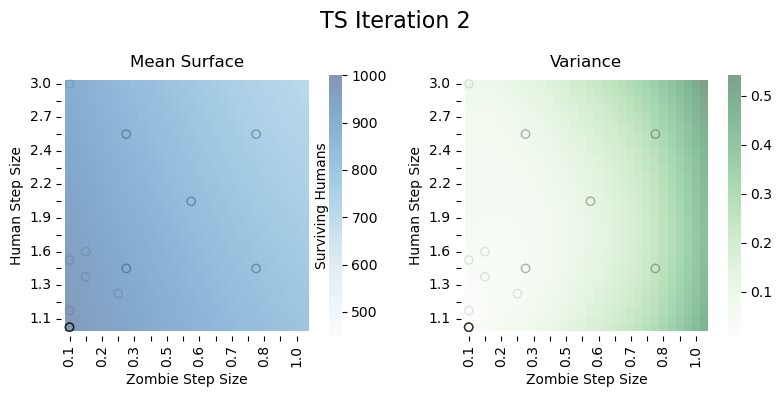

Covariance matrix is not positive semidefinite. Clipping negative eigenvalues.
After iteration 3, we found that 991 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


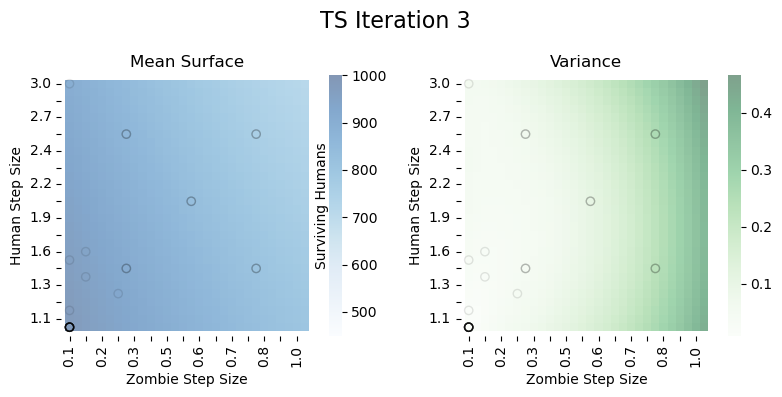

Covariance matrix is not positive semidefinite. Clipping negative eigenvalues.
After iteration 4, we found that 991 humans can survive at zombie_step_size = 0.1, human_step_size = 1.0


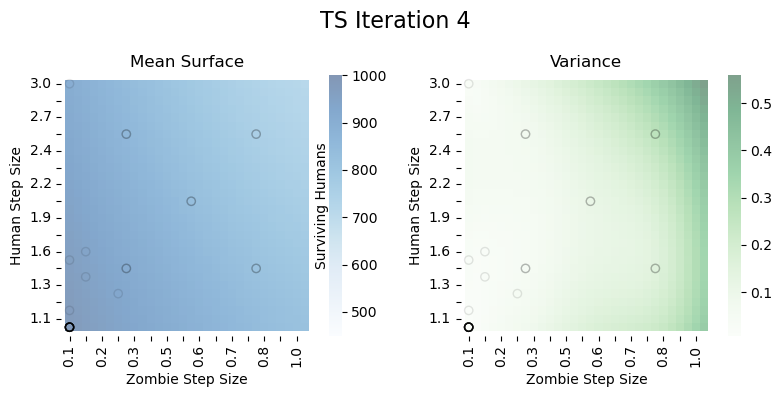

In [10]:
i = 2 # track iteration for plots
while budget > 0:
    # thompson sample for best locations
    best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
    budget -= nts
    
    # get new runs and combine
    Xnew, Xnew_native = generate_inputs(Xgrid, best_ids, id_counter, seeds)
    payloads = list(map(lambda a: json.dumps(list(a)), Xnew_native))
    _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
    sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
    Ynew = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
    # scale outputs
    Ynew = np.log(Ynew)
    Ynew = (Ynew - ymean)/ystd

    X = np.vstack([X, Xnew])
    Y = np.concatenate([Y, Ynew])

    Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
    Ynative = Ynative = np.exp(Y*ystd + ymean)
    best_ix = np.argmax(Ynative)
    print(f"After iteration {i}, we found that {round(Ynative[best_ix])} humans can survive at zombie_step_size = {round(Xnative[best_ix, 0],2)}, human_step_size = {Xnative[best_ix, 1]}")
    gp = hetGP()
    gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), 
           init={'g_bounds':[1e-6, .1]}, maxit=1000)
    #plot_gp_mean(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')
    plot_gp(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')
    #best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
    #budget -= nts
    i += 1


#### Shut EMEWS down

Finally, we close the task queue and worker pools and shut down the EMEWS DB.

In [11]:
if task_queue is not None:
    task_queue.close()
if pool is not None:
    pool.cancel()
if db_started:
    db_tools.stop_db(params['db_path'])

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.11/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped

